# Previsão de Notas de Estudantes - Kaggle Playground S6E1

Este notebook desenvolve modelos de machine learning para prever a variável `exam_score` a partir de dados educacionais sintéticos com 900.000 registros, contendo informações demográficas, hábitos de estudo e fatores ambientais.

## Estrutura

1. Configuração do ambiente  
2. Análise exploratória  
3. Pré-processamento e engenharia de features  
4. Modelagem individual (RF, XGBoost, LightGBM, CatBoost)  
5. Ensemble e geração de submissões


# 1. Configuração do ambiente

-----------

In [5]:
# Instalação de todas as dependências necessárias
!pip install -q optuna xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone


## 1.1 Carregamento dos dados


In [7]:
test = pd.read_csv("/kaggle/input/playground-series-s6e1/test.csv")
train = pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/playground-series-s6e1/test.csv'

In [ ]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


O dataset contém:  

- **Demográficas**: `age`, `gender`, `course`  
- **Hábitos de estudo**: `study_hours`, `class_attendance`, `study_method`  
- **Fatores ambientais**: `internet_access`, `sleep_hours`, `sleep_quality`  
- **Infraestrutura**: `facility_rating`, `exam_difficulty`  
- **Target**: `exam_score`.[file:1]


In [ ]:
test.head(0)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty


#### Estrutura dos Dados de Teste

Os dados de teste não possuem a variável alvo `exam_score`, que é o valor a ser previsto.

In [ ]:
print(train.shape) #dados de treino
print(test.shape) #dados de teste

(630000, 13)
(270000, 12)


#### Dimensões do Dataset

- **Total de registros**: 900.000
- **Dados de treino**: 630.000 (70%)
- **Dados de teste**: 270.000 (30%)

In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64
id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
dtype: int64


#### Qualidade dos Dados

Não foram identificados valores nulos nos datasets de treino e teste, indicando boa qualidade dos dados.

In [ ]:
test.describe()

,id,age,study_hours,class_attendance,sleep_hours
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,20.544137,4.003878,71.982509,7.072070
std,77942.430678,2.260452,2.357741,17.414695,1.745513
min,630000.000000,17.000000,0.080000,40.600000,4.100000
25%,697499.750000,19.000000,1.980000,57.000000,5.600000
50%,764999.500000,21.000000,4.010000,72.600000,7.100000
75%,832499.250000,23.000000,6.050000,87.200000,8.600000
max,899999.000000,24.000000,7.910000,99.400000,9.900000


## 1.2 Separação de Features e Target

Os dados são divididos em features (variáveis independentes) e target (variável dependente).

In [ ]:
#Definição de colunas
target = "exam_score"
id_col = "id"

numeric_features = ["age", "study_hours", "class_attendance", "sleep_hours"]  #dados numéricos
categorical_features = [#dados categóricos -> Nao numericos
    "gender", 
    "course", 
    "internet_access",
    "sleep_quality",
    "study_method",
    "facility_rating",
    "exam_difficulty",
]  
X = train.drop([id_col, target], axis=1) #tira as colunas id_col e o target, mantendo somente as features de treino.
y = train[target] #define o target de treino sendo o Exam_score
X_test = test.drop([id_col], axis=1) #tira o id_col do x de test, visto que não será levado em consideração na analise.

print(X.shape)
print(y.shape)
print(X_test.shape)


(630000, 11)
(630000,)
(270000, 11)


# 2. Análise Exploratória de Dados

-----------


## 2.1 Análise da Variável Target

Nesta seção é realizada a análise exploratória dos dados para compreender as distribuições e correlações.

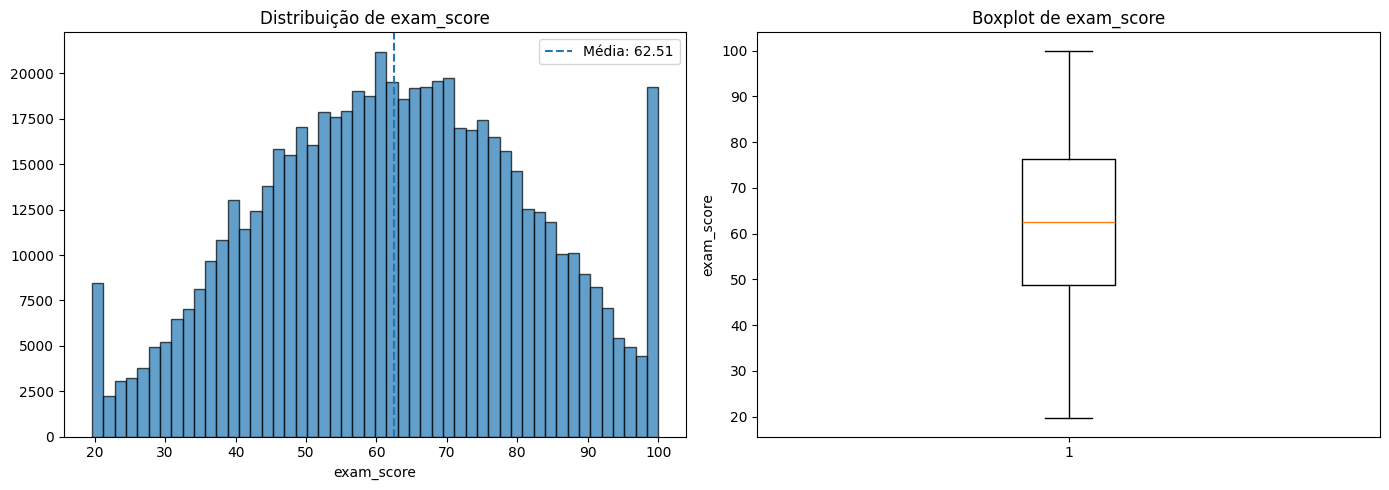

In [ ]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuição de exam_score')
axes[0].set_xlabel('exam_score')
axes[0].axvline(y.mean(), linestyle='--', label=f'Média: {y.mean():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(y)
axes[1].set_title('Boxplot de exam_score')
axes[1].set_ylabel('exam_score')

plt.tight_layout()
plt.show()

Observações:  

- Mediana próxima da média, sugerindo distribuição relativamente simétrica.  
- Maior densidade de valores entre 50 e 75 pontos.  
- A maioria dos estudantes apresenta desempenho de médio a bom.


## 2.2 Correlação entre variáveis numéricas


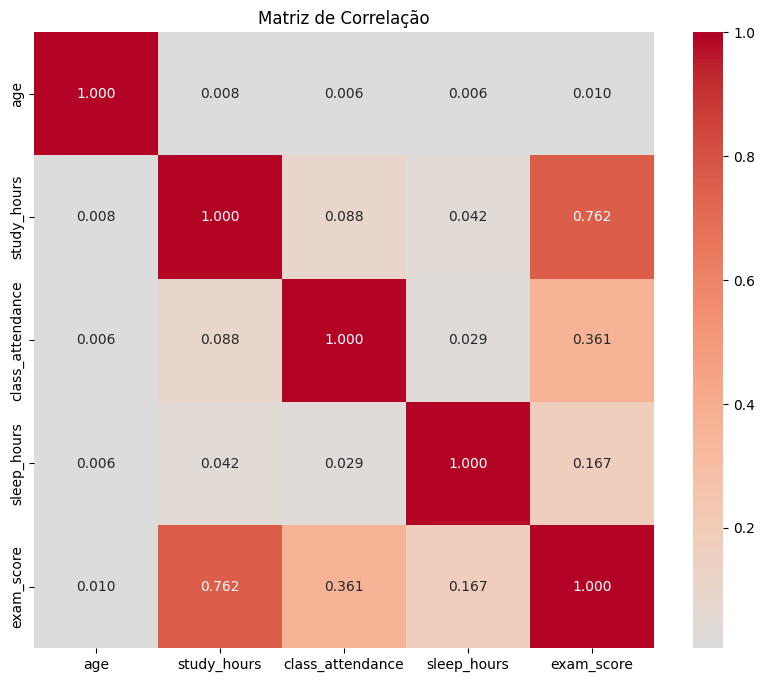

Correlações com o target:
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


In [ ]:
#Correlação entre variáveis numéricas
numeric_data = train[numeric_features + [target]] #osmente features numericas e o que queremos analisar
correlation_matrix = numeric_data.corr() #aplica correlação

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0) #ampa de calor, quanto mais ao vermlehor maior a correlação
plt.title('Matriz de Correlação')
plt.show()
print("Correlações com o target:")
print(correlation_matrix[target].sort_values(ascending=False))


Principais correlações com `exam_score`:  
- `study_hours` com correlação alta positiva (~0.76).  
- `class_attendance` com correlação positiva moderada (~0.36).  
- `sleep_hours` com correlação positiva mais fraca (~0.17).  
- `age` praticamente sem correlação.[file:1]


## 2.3 Análise de Variáveis Categóricas


In [ ]:
from IPython.display import display

# Média de exam_score por categoria
for col in categorical_features:
    means = (
        train.groupby(col)[target]# agrupa cada coluna categórica com o target,
        .mean()    #calculando a média da nota do exame para cada valor da coluna
        .sort_values(ascending=False)
    )
    
    # mostra o nome da coluna
    print(f"\n{col}:")
    display(means)#display evita que o output seja cortado no Jupyter



gender:


gender
other     62.781191
female    62.563220
male      62.175561
Name: exam_score, dtype: float64


course:


course
bba        63.232038
bca        62.586227
b.com      62.537726
b.tech     62.519707
diploma    62.404354
b.sc       62.295491
ba         61.886931
Name: exam_score, dtype: float64


internet_access:


internet_access
yes    62.509172
no     62.478038
Name: exam_score, dtype: float64


sleep_quality:


sleep_quality
good       67.884885
average    62.662000
poor       56.995470
Name: exam_score, dtype: float64


study_method:


study_method
coaching         69.266665
mixed            65.101735
group study      60.531838
online videos    59.727607
self-study       57.700155
Name: exam_score, dtype: float64


facility_rating:


facility_rating
high      66.707126
medium    63.028954
low       57.954546
Name: exam_score, dtype: float64


exam_difficulty:


exam_difficulty
hard        62.671693
moderate    62.606060
easy        62.214401
Name: exam_score, dtype: float64

Dados por categoria (exemplos): 

- `sleep_quality`: boa qualidade de sono tem média claramente maior que qualidade ruim.  
- `study_method`: métodos com coaching apresentam maiores médias; autoestudo isolado fica entre as menores.  
- `facility_rating`: melhores avaliações de infraestrutura se associam a notas mais altas.


# 3. Pré-processamento de Dados

--------

## 3.1 Transformação de Variáveis Categóricas

As variáveis categóricas precisam ser convertidas em numéricas para utilização nos modelos de machine learning.

#### Processo de Label Encoding

É aplicado o LabelEncoder para transformar variáveis categóricas em numéricas, mantendo a consistência entre os datasets de treino e teste.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Passo 1:  Fazer as copias idenpendentes dos daods para protegrer x e x_test
X_transf = X.copy()
X_test_transf = X_test.copy()
#print(X_enconder) #vemos que tem dados numericos e categoricos. So queremos os categoricos para manipulação de string

# Passo 2: separar as copias com apenas dados categoricos
X_transf_categories = X_transf[categorical_features]
X_test_transf_categories = X_test_transf[categorical_features]
#print(X_enconder_cat) #agora vemos que so ficou os dados categoricos

# Passo 3: Loop para aplicar a transformação para cada coluna
for col in categorical_features: #para cada coluna de variavel categorica:
  le = LabelEncoder() #modelo label encoder
  combined = pd.concat([
      X_transf_categories[col],
      X_test_transf_categories[col]
  ])  #junta o dataframe de treino e de teste em um só para garantir que nao faltara nenhuma label na analise

  le.fit(combined.astype(str)) #aplica o modelo de enconder na variavel do dados combinados
   # -  Primeiro converte para string
   # - Remove duplicatas
   # - Ordena alfabeticamente as labels
   # - Cria o mapeamento interno. Exemplo -> [´Female', 'Male','orther'] -> [0,1,2]
   # O astype(str)  evita que dados numericos aleatorios ou tipo NAN sejam levado em consideração na transformação

   #Passo 4: aplicar nos dataframes de teste e treino
  X_transf[col] = le.transform(X_transf_categories[col].astype(str)) #para cad coluna de treino aplica a transformação pelo modelo acima
  X_test_transf[col] = le.transform(X_test_transf_categories[col].astype(str)) #para cad coluna de teste aplica a transformação pelo modelo acima

#passo 5: visualizar os dataframes como ficaram:
print(X_transf) #TREINo
print(X_test_transf) #test


        age  gender  course  study_hours  class_attendance  internet_access  \
0        21       0       1         7.91              98.8                0   
1        18       2       6         4.95              94.8                1   
2        20       0       1         4.68              92.6                1   
3        19       1       1         2.00              49.5                1   
4        23       1       5         7.65              86.9                1   
...     ...     ...     ...          ...               ...              ...   
629995   18       0       2         4.86              70.7                1   
629996   21       0       3         7.08              54.4                1   
629997   24       1       5         0.64              44.2                1   
629998   20       1       0         1.54              75.1                1   
629999   18       2       2         3.94              75.3                1   

        sleep_hours  sleep_quality  study_method  f

## 3.2 Engenharia de Features

Novas features são criadas para capturar relações não-lineares e interações entre variáveis existentes.

In [ ]:
def cria_features_otimizadas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    eps = 1e-6

    # Polinômios (apenas de features importantes)
    for col in ["study_hours", "class_attendance", "sleep_hours"]:
        df[f"{col}_sq"] = df[col] ** 2
        df[f"{col}_cube"] = df[col] ** 3
        df[f"{col}_4th"] = df[col] ** 4
        df[f"{col}_5th"] = df[col] ** 5

    # Polinômios para sleep_quality
    df["sleep_quality_sq"] = df["sleep_quality"] ** 2
    df["sleep_quality_cube"] = df["sleep_quality"] ** 3

    # Raízes e logarítmos
    df["sqrt_study"] = np.sqrt(df["study_hours"].clip(lower=0))
    df["sqrt_attendance"] = np.sqrt(df["class_attendance"].clip(lower=0))
    df["sqrt_sleep"] = np.sqrt(df["sleep_hours"].clip(lower=0))

    df["log_study"] = np.log1p(df["study_hours"])
    df["log_attendance"] = np.log1p(df["class_attendance"])
    df["log_sleep"] = np.log1p(df["sleep_hours"])

    # Interações cruzadas
    df["study_x_attendance"] = df["study_hours"] * df["class_attendance"]
    df["study_x_sleep"] = df["study_hours"] * df["sleep_hours"]
    df["study_x_age"] = df["study_hours"] * df["age"]
    df["attendance_x_sleep"] = df["class_attendance"] * df["sleep_hours"]
    df["attendance_x_age"] = df["class_attendance"] * df["age"]
    df["sleep_x_age"] = df["sleep_hours"] * df["age"]

    df["study_x_attendance_x_sleep"] = (
        df["study_hours"] * df["class_attendance"] * df["sleep_hours"]
    )
    df["study_x_sleep_quality"] = df["study_hours"] * df["sleep_quality"]
    df["study_x_difficulty"] = df["study_hours"] * df["exam_difficulty"]

    # Ratios
    df["study_per_sleep"] = df["study_hours"] / (df["sleep_hours"] + eps)
    df["study_per_attendance"] = df["study_hours"] / (df["class_attendance"] + eps)
    df["attendance_per_sleep"] = df["class_attendance"] / (df["sleep_hours"] + eps)
    df["sleep_per_study"] = df["sleep_hours"] / (df["study_hours"] + eps)
    df["attendance_per_study"] = df["class_attendance"] / (df["study_hours"] + eps)
    df["age_per_study"] = df["age"] / (df["study_hours"] + eps)

    # Binning
    df["study_bin_10"] = pd.cut(df["study_hours"], bins=10, labels=False)
    df["sleep_bin_10"] = pd.cut(df["sleep_hours"], bins=10, labels=False)
    df["attendance_bin_10"] = pd.cut(df["class_attendance"], bins=10, labels=False)

    df["study_bin"] = pd.cut(df["study_hours"], [-1, 2, 4, 6, 8, 100], labels=False)
    df["sleep_bin"] = pd.cut(df["sleep_hours"], [-1, 5, 6, 7, 8, 100], labels=False)
    df["attendance_bin"] = pd.cut(
        df["class_attendance"], [-1, 60, 75, 85, 95, 101], labels=False
    )

    # Ranks
    df["study_rank"] = df["study_hours"].rank(pct=True)
    df["attendance_rank"] = df["class_attendance"].rank(pct=True)
    df["sleep_rank"] = df["sleep_hours"].rank(pct=True)

    # Flags booleanos
    df["high_performer"] = (
        (df["class_attendance"] >= 90) & (df["study_hours"] >= 6)
    ).astype(int)
    df["high_study"] = (df["study_hours"] >= 7).astype(int)
    df["low_attendance"] = (df["class_attendance"] < 70).astype(int)

    df["high_perf_ideal_sleep"] = (
        df["high_performer"] & ((df["sleep_hours"] >= 7) & (df["sleep_hours"] <= 9))
    ).astype(int)
    df["high_study_low_attend"] = (
        (df["study_hours"] >= 7) & (df["class_attendance"] < 80)
    ).astype(int)

    # Estatísticas agregadas
    df["avg_core_features"] = (
        df["study_hours"] + df["class_attendance"] + df["sleep_hours"]
    ) / 3
    df["sum_core_features"] = (
        df["study_hours"] + df["class_attendance"] + df["sleep_hours"]
    )
    df["prod_core_features"] = (
        df["study_hours"] * df["class_attendance"] * df["sleep_hours"]
    )

    df["study_deviation"] = df["study_hours"] - df["study_hours"].mean()
    df["attendance_deviation"] = (
        df["class_attendance"] - df["class_attendance"].mean()
    )

    # Eficiências
    df["efficiency_1"] = (df["study_hours"] * df["class_attendance"]) / (
        df["sleep_hours"] + 1
    )
    df["efficiency_2"] = (df["study_hours"] * df["sleep_quality"]) / (df["age"] + eps)

    df["preparation_score"] = (
        df["study_hours"] * 0.4
        + df["class_attendance"] * 0.4
        + df["sleep_hours"] * 0.2
    )
    df["environment_score"] = (
        df["facility_rating"] * df["sleep_quality"] * df["internet_access"]
    )

    # Gaps
    df["sleep_gap_8"] = (df["sleep_hours"] - 8.0).abs()
    df["attendance_gap_100"] = (df["class_attendance"] - 100.0).abs()
    df["study_gap_6"] = (df["study_hours"] - 6.0).abs()

    # Trigonométricas
    df["sin_study"] = np.sin(df["study_hours"] / 12 * np.pi)
    df["cos_study"] = np.cos(df["study_hours"] / 12 * np.pi)
    df["sin_sleep"] = np.sin(df["sleep_hours"] / 12 * np.pi)
    df["cos_sleep"] = np.cos(df["sleep_hours"] / 12 * np.pi)

    # Normalização
    df["study_normalized"] = (df["study_hours"] - df["study_hours"].min()) / (
        df["study_hours"].max() - df["study_hours"].min() + eps
    )
    df["attendance_normalized"] = (
        df["class_attendance"] - df["class_attendance"].min()
    ) / (df["class_attendance"].max() - df["class_attendance"].min() + eps)

    return df

In [ ]:
print("CRIANDO FEATURES OTIMIZADAS")

X_transf = cria_features_otimizadas(X_transf)
X_test_transf = cria_features_otimizadas(X_test_transf)

print(f"\nFeatures originais: 11")
print(f"Features criadas: {X_transf.shape[1] - 11}")
print(f"Total de features: {X_transf.shape[1]}")
print("\nDataset com features enriquecidas criado.")

X_transf.head()

CRIANDO FEATURES OTIMIZADAS

Features originais: 11
Features criadas: 67
Total de features: 78

Dataset com features enriquecidas criado.


,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,...,environment_score,sleep_gap_8,attendance_gap_100,study_gap_6,sin_study,cos_study,sin_sleep,cos_sleep,study_normalized,attendance_normalized
0,21,0,1,7.91,98.8,0,4.9,0,3,1,...,0,3.1,1.2,1.91,0.877565,-0.479458,0.958820,0.284015,1.000000,0.989796
1,18,2,6,4.95,94.8,1,4.7,2,4,2,...,4,3.3,5.2,1.05,0.962455,0.271440,0.942641,0.333807,0.621967,0.921769
2,20,0,1,4.68,92.6,1,5.8,2,0,0,...,0,2.2,7.4,1.32,0.940881,0.338738,0.998630,0.052336,0.587484,0.884354
3,19,1,1,2.00,49.5,1,8.3,0,1,0,...,0,0.3,50.5,4.00,0.500000,0.866025,0.824126,-0.566406,0.245211,0.151361
4,23,1,5,7.65,86.9,1,9.6,1,4,0,...,0,1.6,13.1,1.65,0.908143,-0.418660,0.587785,-0.809017,0.966794,0.787415


In [ ]:
df_corr = X_transf.copy()
df_corr["target"] = y_transf
corr_target = df_corr.corr(numeric_only=True)["target"].drop("target")

# Top 15 (mais relevantes em valor absoluto)
top15 = corr_target.abs().sort_values(ascending=False).head(15)

# Plot simples
plt.figure(figsize=(8, 5))
top15[::-1].plot(kind="barh")
plt.title("Top 15 Features mais correlacionadas com o target")
plt.xlabel("Correlação absoluta")
plt.tight_layout()
plt.show()

NameError: name 'X_transf' is not defined

# 4. Função de avaliação (cross-validation)

--------

Nesta seção são definidos e aplicados os esquemas de validação cruzada par Modelos individuais (Random Forest, XGBoost, LightGBM, CatBoost).  


- Validação dos modelos:

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import numpy as np

def evaluate_model_cv(model, X, y, cv=5):
    """
    Avalia um modelo usando KFold e retorna os RMSE de cada fold.
    Usa validação MANUAL para TODOS os modelos (evita travamento do cross_val_score).
    """
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kfold.split(X):
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]

        # Clone para cada fold
        model_fold = clone(model)
        
        # Fit (sem n_jobs=-1 para evitar sobrecarga)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predict e RMSE
        pred = model_fold.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, pred))
        rmse_scores.append(rmse)

    return np.array(rmse_scores)


# 5. Modelos

---------

In [ ]:
test_ids = test["id"].values  # IDs para TODAS as submissões

## 5.1. Decision Treee


---------------

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Árvore de decisão simples com 1 árvore (baseline)
dt_model = DecisionTreeRegressor(
    max_depth=None,      # Árvore completa (sem poda)
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Treina com todos os dados
dt_model.fit(X_transf, y)

# Previsão no teste
pred_dt_test = dt_model.predict(X_test_transf)

# Submissão imediata
submission_dt = pd.DataFrame({
    'id': test_ids,
    'exam_score': pred_dt_test
})
submission_dt.to_csv('submission_dt_individual.csv', index=False)

print("Submissão Árvore de Decisão (1 árvore) salva")
print("RMSE esperado: baseline simples")
print(submission_dt.head())


Submissão Árvore de Decisão (1 árvore) salva
RMSE esperado: baseline simples
       id  exam_score
0  630000   60.885714
1  630001   70.460000
2  630002   84.687500
3  630003   43.862500
4  630004   53.571429


## 5.2. Random Florest

--------------

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
n_estimators_list = [5, 10, 20, 50, 100]# Lista de valores para o número de árvores

rmse_means = [] #Armazena as media RMSE

for n in n_estimators_list:

    rf_model = RandomForestRegressor( #modelo random forest
        n_estimators=n, #numero de arvores que irao fazer analise -> pega do vetor acima
        max_depth=15,   #profundidade maxima das arvores
        random_state=42, #random state para garantir reprodutibilidade
        n_jobs=-1
    )

    #uso da validação cruzada no modelo acima
    # X_transf -> Features de treino
    # y -> Target de treino
    # cv -> numero de divisoes
    rmse_scores = evaluate_model_cv(rf_model, X_transf, y, cv=5)

    #o evaluate_model irá devolver o rmse_scores em positivo
    #ele devolverá um valor para cada fold, no caso um array com 5 valores
    #exemplo: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    rmse_means.append(rmse_mean)
    print(f"n_estimators = {n} -> RMSE médio: {rmse_mean:.4f}")#print do desempenho para cada numero de arvores

# identificar o melhor numero de arvores (menor RMSE medio)
best_idx = np.argmin(rmse_means)
best_n_estimators = n_estimators_list[best_idx]
best_rmse = rmse_means[best_idx]

print("\nMelhor configuração encontrada:")
print(f"n_estimators = {best_n_estimators} com RMSE médio = {best_rmse:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, rmse_means, marker='o')

plt.xlabel("Número de Árvores (n_estimators)")
plt.ylabel("RMSE médio (Validação Cruzada)")
plt.title("Evolução do RMSE médio com o número de árvores - Random Forest")
plt.grid(True)
plt.show()

In [ ]:
print(f"Treinando modelo final com n_estimators = {best_n_estimators}...")

rf_final = RandomForestRegressor(
    n_estimators=best_n_estimators,  # Melhor valor encontrado
    max_depth=15, 
    random_state=42,
    n_jobs=-1  # Usa todos os núcleos disponíveis
)

rf_final.fit(Xtransf, y)  # Treina com todos os dados de treino

y_pred_test = rf_final.predict(Xtesttransf)  # Previsão no conjunto de teste

submission_rf = pd.DataFrame({
    'id': test_ids,       # Usa test_ids (definido anteriormente)
    'examscore': y_pred_test  # Nome correto da coluna do Kaggle
})

submission_rf.to_csv('submission_rf_individual.csv', index=False)  # Nome padronizado
print("Primeiras linhas da submissão Random Forest:")
print(submission_rf.head())

## 5.3. XGBoost


--------

In [ ]:
import optuna
from xgboost import XGBRegressor

#Função objetivo para o Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'n_jobs': 1,
        'random_state': 42
    }
    #Criar modelo XGBoost
    xgb_model = XGBRegressor(**params)
    
    #Uso da validação cruzada no modelo acima
    # X_transf -> Features de treino
    # y -> Target de treino
    # cv -> numero de divisoes
    rmse_scores = evaluate_model_cv(xgb_model, X_transf, y, cv=5)
    
    #O evaluate_model irá devolver o rmse_scores em positivo
    #Ele devolverá um valor para cada fold, no caso um array com 5 valores
    #Exemplo: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    
    return rmse_mean

#Criar estudo Optuna e otimizar
print("Iniciando otimização de hiperparâmetros com Optuna...")
study = optuna.create_study(direction='minimize')  # Minimizar RMSE
study.optimize(objective, n_trials=25, show_progress_bar= True)  # Número de tentativas
best_params = study.best_params#Identificar os melhores hiperparâmetros
best_rmse = study.best_value

print("\nMelhor configuração encontrada:")
print(f"Melhores hiperparâmetros: {best_params}")
print(f"RMSE médio = {best_rmse:.4f}")

## 5.4. LightGBM

------------

In [ ]:
import optuna
from lightgbm import LGBMRegressor


#Função objetivo para o Optuna
def objective(trial):
    #Definir os hiperparâmetros a serem otimizados
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2500),  # Número de árvores
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Profundidade máxima das árvores
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Taxa de aprendizado
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Fração de amostras para cada árvore
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Fração de features
        'random_state': 42,
        'n_jobs': 1
    }
    
    #Criar modelo LightGBM
    lgbm_model = LGBMRegressor(**params)
    
    #Uso da validação cruzada no modelo acima
    # X_transf -> Features de treino
    # y -> Target de treino
    # cv -> numero de divisoes
    rmse_scores = evaluate_model_cv(lgbm_model, X_transf, y, cv=5)
    
    #O evaluate_model irá devolver o rmse_scores em positivo
    #Ele devolverá um valor para cada fold, no caso um array com 5 valores
    #Exemplo: [2.31, 2.45, 2.28, 2.40, 2.35]
    rmse_mean = rmse_scores.mean()
    
    return rmse_mean

#Criar estudo Optuna e otimizar
print("Iniciando otimização de hiperparâmetros com Optuna...")
study = optuna.create_study(direction='minimize')  # Minimizar RMSE
study.optimize(objective, n_trials=25, show_progress_bar= True)  # Número de tentativas
best_params = study.best_params#Identificar os melhores hiperparâmetros
best_rmse = study.best_value


print("\nMelhor configuração encontrada:")
print(f"Melhores hiperparâmetros: {best_params}")
print(f"RMSE médio = {best_rmse:.4f}")

##  5.5. Catboost

----------------

In [ ]:
import optuna
from catboost import CatBoostRegressor
import numpy as np

# Função objetivo para Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'bootstrap_type': 'Bernoulli',
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'thread_count': -1,  #todos os nucleos
        'verbose': False
    }
    
    # Criar modelo com os parâmetros sugeridos
    model = CatBoostRegressor(**params)
    rmse_scores = evaluate_model_cv(model, X_transf, y, cv=5)
    mean_rmse = np.mean(rmse_scores)
    
    return mean_rmse

# Executar otimização
print("Iniciando otimização de hiperparâmetros com Optuna...")
print(f"Dataset: {X_transf.shape[0]} linhas, {X_transf.shape[1]} features")
print("="*60)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Resultados
print("\n" + "="*60)
print("RESULTADOS DA OTIMIZAÇÃO")
print("="*60)
print(f"Melhor RMSE (média CV): {study.best_value:.4f}")
print("\nMelhores parâmetros encontrados:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
print("="*60)

# 6. Submissões individuais por modelo

------------

## 6.1. Modelo XGBoost

In [ ]:
from xgboost import XGBRegressor

# Melhores hiperparâmetros XGBoost do Optuna (RMSE: 8.7300)
best_params_xgb = {
    'n_estimators': 1145,
    'max_depth': 7,
    'learning_rate': 0.04269262045629722,
    'subsample': 0.8739697774837054,
    'colsample_bytree': 0.9928865587917701,
    'colsample_bylevel': 0.9744161297574184,
    'colsample_bynode': 0.6681144843894893,
    'reg_alpha': 0.5332289367881878,
    'reg_lambda': 1.7393417559849508e-05,
    'gamma': 4.524129691822362,
    'min_child_weight': 2
}

# Treina XGBoost com melhores parâmetros em todos os dados de treino
xgb_model_individual = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
xgb_model_individual.fit(X_transf, y)

# Previsão no conjunto de teste
pred_xgb_test = xgb_model_individual.predict(X_test_transf)

# Gera arquivo de submissão
submission_xgb = pd.DataFrame({'id': test_ids, 'exam_score': pred_xgb_test})
submission_xgb.to_csv('submission_xgb_individual.csv', index=False)
print("Submissão XGBoost individual salva")
print(submission_xgb.head())


## 6.2. Modelo LightGBM

In [ ]:
from lightgbm import LGBMRegressor

# Melhores hiperparâmetros LightGBM do Optuna (RMSE: 8.7358)
best_params_lgbm = {
    'n_estimators': 2474,
    'max_depth': 14,
    'learning_rate': 0.04729004562661403,
    'subsample': 0.9237994273727859,
    'colsample_bytree': 0.7615157452816664
}

# Treina LightGBM com melhores parâmetros em todos os dados de treino
lgbm_model_individual = LGBMRegressor(**best_params_lgbm, random_state=42, verbose=-1, n_jobs=-1)
lgbm_model_individual.fit(X_transf.astype(np.float32), y.astype(np.float32))

# Previsão no conjunto de teste
pred_lgbm_test = lgbm_model_individual.predict(X_test_transf.astype(np.float32))

# Gera arquivo de submissão
submission_lgbm = pd.DataFrame({'id': test_ids, 'exam_score': pred_lgbm_test})
submission_lgbm.to_csv('submission_lgbm_individual.csv', index=False)
print("Submissão LightGBM individual salva")
print(submission_lgbm.head())

## 6.3 Moddelo CatBoost

In [ ]:
from catboost import CatBoostRegressor

# Melhores hiperparâmetros CatBoost do Optuna (RMSE: 8.7490)
best_params_catboost = {
    'iterations': 2458,
    'depth': 7,
    'learning_rate': 0.05401634937628759,
    'subsample': 0.9613602990809382
}

# Treina CatBoost com melhores parâmetros em todos as dados de treino
catboost_model_individual = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=False)
catboost_model_individual.fit(X_transf, y)

# Previsão no conjunto de teste
pred_catboost_test = catboost_model_individual.predict(X_test_transf)

# Gera arquivo de submissão
submission_catboost = pd.DataFrame({'id': test_ids, 'exam_score': pred_catboost_test})
submission_catboost.to_csv('submission_catboost_individual.csv', index=False)
print("Submissão CatBoost individual salva")
print(submission_catboost.head())


# 7. Ensemble (XGBoost + LightGBM + CatBoost)

-------

In [ ]:
import gc
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
print("=" * 50)
print("ENSEMBLE COM VALIDAÇÃO CRUZADA")
print("=" * 50)
print(f"Total features: {X_transf.shape[1]}")
print(f"Samples treino: {X_transf.shape[0]}")
print(f"Samples teste: {X_test_transf.shape[0]}")

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=1145,
    max_depth=7,
    learning_rate=0.04269262045629722,
    subsample=0.8739697774837054,
    colsample_bytree=0.9928865587917701,
    colsample_bylevel=0.9744161297574184,
    colsample_bynode=0.6681144843894893,
    reg_alpha=0.5332289367881878,
    reg_lambda=1.7393417559849508e-05,
    gamma=4.524129691822362,
    min_child_weight=2,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

# LightGBM - Melhores parâmetros do Optuna (RMSE: 8.7358)
lgbm_model = LGBMRegressor(
    n_estimators=2474,
    max_depth=14,
    learning_rate=0.04729004562661403,
    subsample=0.9237994273727859,
    colsample_bytree=0.7615157452816664,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    max_bin=255,
    force_col_wise=True,
    min_data_in_leaf=20
)

# CatBoost - Melhores parâmetros do Optuna (RMSE: 8.7490)
catboost_model = CatBoostRegressor(
    iterations=2458,
    depth=7,
    learning_rate=0.05401634937628759,
    subsample=0.9613602990809382,
    random_seed=42,
    verbose=False,
    thread_count=-1
)

In [ ]:
#peso para cada modelo
peso_xgb = 0.5
peso_lgbm = 0.35
peso_catboost = 0.15

#ARMAZENA O RMSE DE CADA FOLD DA VALIDAÇÃO CRUZADA
rmse_xgb_cv = []
rmse_lgbm_cv = []
rmse_catboost_cv = []
rmse_ensemble_simples_cv = []
rmse_ensemble_ponderado_cv = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nExecutando validação cruzada...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_transf), 1):
    print(f"\nFold {fold}/5:", end=" ")
    
    X_train_fold = X_transf.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold = X_transf.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]
    
    # XGBoost
    xgb_fold = XGBRegressor(**xgb_model.get_params())
    xgb_fold.fit(X_train_fold, y_train_fold)
    pred_xgb_val = xgb_fold.predict(X_val_fold)
    rmse_xgb = np.sqrt(mean_squared_error(y_val_fold, pred_xgb_val))
    rmse_xgb_cv.append(rmse_xgb)
    print(f"XGB={rmse_xgb:.4f}", end=" | ")
    
    # LightGBM
    lgbm_fold = LGBMRegressor(**lgbm_model.get_params())
    lgbm_fold.fit(
        X_train_fold.astype(np.float32),
        y_train_fold.astype(np.float32),
    )
    pred_lgbm_val = lgbm_fold.predict(X_val_fold.astype(np.float32))
    rmse_lgbm = np.sqrt(mean_squared_error(y_val_fold, pred_lgbm_val))
    rmse_lgbm_cv.append(rmse_lgbm)
    print(f"LGBM={rmse_lgbm:.4f}", end=" | ")
    
    # CatBoost
    catboost_fold = CatBoostRegressor(**catboost_model.get_params())
    catboost_fold.fit(X_train_fold, y_train_fold)
    pred_catboost_val = catboost_fold.predict(X_val_fold)
    rmse_catboost = np.sqrt(mean_squared_error(y_val_fold, pred_catboost_val))
    rmse_catboost_cv.append(rmse_catboost)
    print(f"CAT={rmse_catboost:.4f}", end=" | ")
    
    # Ensemble simples
    pred_ensemble_simples_val = (
        pred_xgb_val + pred_lgbm_val + pred_catboost_val
    ) / 3
    rmse_ensemble_simples = np.sqrt(mean_squared_error(y_val_fold, pred_ensemble_simples_val))
    rmse_ensemble_simples_cv.append(rmse_ensemble_simples)
    print(f"ENS_SIMPLES={rmse_ensemble_simples:.4f}", end=" | ")
    
    # Ensemble ponderado
    pred_ensemble_ponderado_val = (
        pred_xgb_val * peso_xgb +
        pred_lgbm_val * peso_lgbm +
        pred_catboost_val * peso_catboost
    )
    rmse_ensemble_ponderado = np.sqrt(mean_squared_error(y_val_fold, pred_ensemble_ponderado_val))
    rmse_ensemble_ponderado_cv.append(rmse_ensemble_ponderado)
    print(f"ENS_PONDERADO={rmse_ensemble_ponderado:.4f}")
    
    gc.collect()

In [ ]:
# Treino final nos dados completos
xgb_model.fit(X_transf, y)
lgbm_model.fit(X_transf.astype(np.float32), y.astype(np.float32))
catboost_model.fit(X_transf, y)

# Previsões no teste
pred_xgb = xgb_model.predict(X_test_transf)
pred_lgbm = lgbm_model.predict(X_test_transf.astype(np.float32))
pred_catboost = catboost_model.predict(X_test_transf)

In [ ]:
# Ensemble simples e ponderado
pred_ensemble_simples = (pred_xgb + pred_lgbm + pred_catboost) / 3

pred_ensemble_ponderado = (
    pred_xgb * peso_xgb
    + pred_lgbm * peso_lgbm
    + pred_catboost * peso_catboost
)

In [ ]:
# Submissão: ensemble simples
submission_simples = pd.DataFrame(
    {
        "id": test_ids,
        "exam_score": pred_ensemble_simples,
    }
)
submission_simples.to_csv("submission_ensemble_simples.csv", index=False)

In [ ]:
# Submissão: ensemble ponderado
submission_ponderado = pd.DataFrame(
    {
        "id": test_ids,
        "exam_score": pred_ensemble_ponderado,
    }
)
submission_ponderado.to_csv("submission_ensemble_ponderado.csv", index=False)